## Numta Recognizer (Bangla Handwriting Digit Recognizer)

In [159]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout,BatchNormalization
from keras.optimizers import Adamax
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras import backend as k
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Step 1: Process the data

###### dataset comes from six sources

In [160]:
#Declaring constants
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=32 # The images will be resized to 28x28 pixels

In [161]:
data_dir=os.path.join('NumtaDB')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

Image Processing

In [162]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):
    '''reads images from the filepaths, resizes them (if given), and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: pass image label filepaths while processing training data, defaults to None while processing testing data
        resize_dim: if given, the image is resized to resize_dim x resize_dim (optional)
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # images loaded in color (BGR)
        #ret,img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        #img = cv2.bilateralFilter(img,9,75,75)
        #img = cv2.medianBlur(img,5)
        #img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
        #img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # cnahging colorspace to GRAY
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
        #X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv2.filter2D(img, -1, kernel)
        #thresh = 200
        #maxValue = 255
        #th, img = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY);
        #ret,img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y
        
def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: If the images are plotted after resizing, pass 'processed' to phase argument. 
            It will plot the image and its true label. If the image is plotted after prediction 
            phase, pass predicted class probabilities to y_pred and 'prediction' to the phase argument. 
            It will plot the image, the true label, and it's top 3 predictions with highest probabilities.
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
#         img_sq=np.squeeze(img,axis=2)
#         plt.imshow(img_sq,cmap='gray')
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [163]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [164]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 32, 32), (72045, 10))

Sample Data

In [165]:
X_show_all=X_train_all

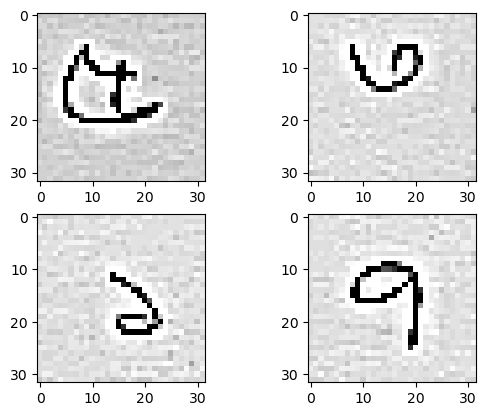

In [166]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

Histogram of digit

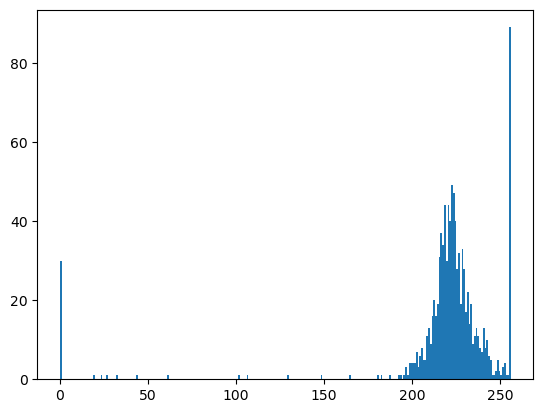

In [167]:
imgg=X_train_all[1]
hist = cv2.calcHist([imgg],[0],None,[256],[0,256])
plt.hist(imgg.ravel(),256,[0,256])
 
# show the plotting graph of an image

plt.show()

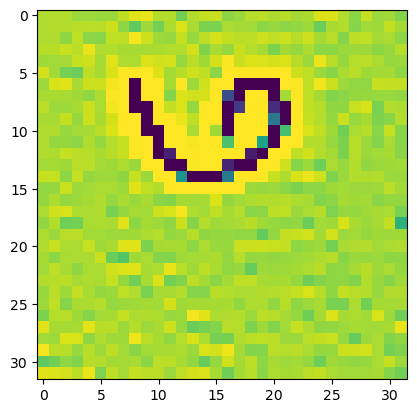

In [168]:
plt.imshow(X_train_all[1])

In [169]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [170]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [171]:
X_tshow_all=X_test_all
X_tshow_all.shape

(17626, 32, 32)

Converting to 1 color channel

In [172]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],32, 32,1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],32, 32,1).astype('float32')

In [173]:
X_train_all.shape

(72045, 32, 32, 1)

Normalizing

In [174]:
X_train_all = X_train_all/255
X_test_all=X_test_all/255

Next, we are going to randomly choose 85% of the training data and use it to train our neural network. The remaining 15% images are going to be our validation data.

In [175]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.85)
# train data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]

Step 2: Design the model

In [176]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def my_model(img_size=32, channels=1):
    model = models.Sequential()
    input_shape = (img_size, img_size, channels)

    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    return model

model = my_model()
model.summary()



Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_218 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 conv2d_219 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_109 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_150 (Dropout)       (None, 16, 16, 64)        0         
                                                                 
 conv2d_220 (Conv2D)         (None, 16, 16, 128)     

Model Training

In [177]:
path_model = 'model_filter.h5'
checkpoint = ModelCheckpoint(filepath=path_model)

# Use data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-3))

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) / 64,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/30
956/956 [==============================] - 504s 524ms/step - loss: 1.8794 - accuracy: 0.3062 - val_loss: 1.3413 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 2/30
956/956 [==============================] - 483s 504ms/step - loss: 0.6305 - accuracy: 0.7962 - val_loss: 0.2767 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 3/30
956/956 [==============================] - 480s 502ms/step - loss: 0.3429 - accuracy: 0.8990 - val_loss: 0.1334 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 4/30
956/956 [==============================] - 495s 517ms/step - loss: 0.2625 - accuracy: 0.9241 - val_loss: 0.1125 - val_accuracy: 0.9703 - lr: 0.0010
Epoch 5/30
956/956 [==============================] - 485s 507ms/step - loss: 0.2352 - accuracy: 0.9341 - val_loss: 0.1696 - val_accuracy: 0.9586 - lr: 0.0010
Epoch 6/30
956/956 [==============================] - 482s 503ms/step - loss: 0.2112 - accuracy: 0.9420 - val_loss: 0.1101 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 7/30
956/956 [==========================

In [180]:
model.save('numta.h5')

Result Analysis

In [292]:

# Calculate average accuracy and validation loss
average_accuracy = np.mean(history.history['accuracy'])
average_val_loss = np.mean(history.history['val_loss'])

print('Average Accuracy:', average_accuracy)
print('Average Validation Loss:', average_val_loss)

Average Accuracy: 0.9326676328976949
Average Validation Loss: 0.13107800607879957


In [179]:
predictions_prob=model.predict(X_test_all) # get predictions for all the test data

551/551 [==============================] - 62s 112ms/step


In [181]:
n_sample=200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

In [283]:
import matplotlib.pyplot as plt

def imshow_group(X, y=None, y_pred=None, phase='Images', figsize=(23, 23)):
    num_images = X.shape[0]
    num_rows = int(np.ceil(num_images / 5))
    fig, axes = plt.subplots(num_rows, 7, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.axis('off')
        if i < num_images:
            image = X[i]
            ax.imshow(image)
            if y is not None:
                true_label = y[i]
                if y_pred is not None:
                    pred_label = np.argmax(y_pred[i])
                    title = 'True: {}\nPred: {}'.format(true_label, pred_label)
                    if pred_label != true_label:
                        title_color = 'red'
                    else:
                        title_color = 'blue'
                    ax.set_title(title, fontsize=10, color=title_color)
                    ax.annotate(f'True: {true_label}', xy=(1.02, 0.5), xycoords='axes fraction', fontsize=10, va='center')
                else:
                    ax.set_title('True: {}'.format(true_label), fontsize=10)
                    ax.annotate(f'True: {true_label}', xy=(1.02, 0.5), xycoords='axes fraction', fontsize=10, va='center')
            elif y_pred is not None:
                pred_label = np.argmax(y_pred[i])
             #   ax.set_title('Pred: {}'.format(pred_label), fontsize=10)
                ax.annotate(f'Pred: {pred_label}', xy=(1.02, 0.5), xycoords='axes fraction', fontsize=10, va='center')

    fig.suptitle(phase, fontsize=14)
    fig.subplots_adjust(top=0.90, bottom=0.05)  # Adjust the top and bottom parameters to reduce blank space
    plt.show()


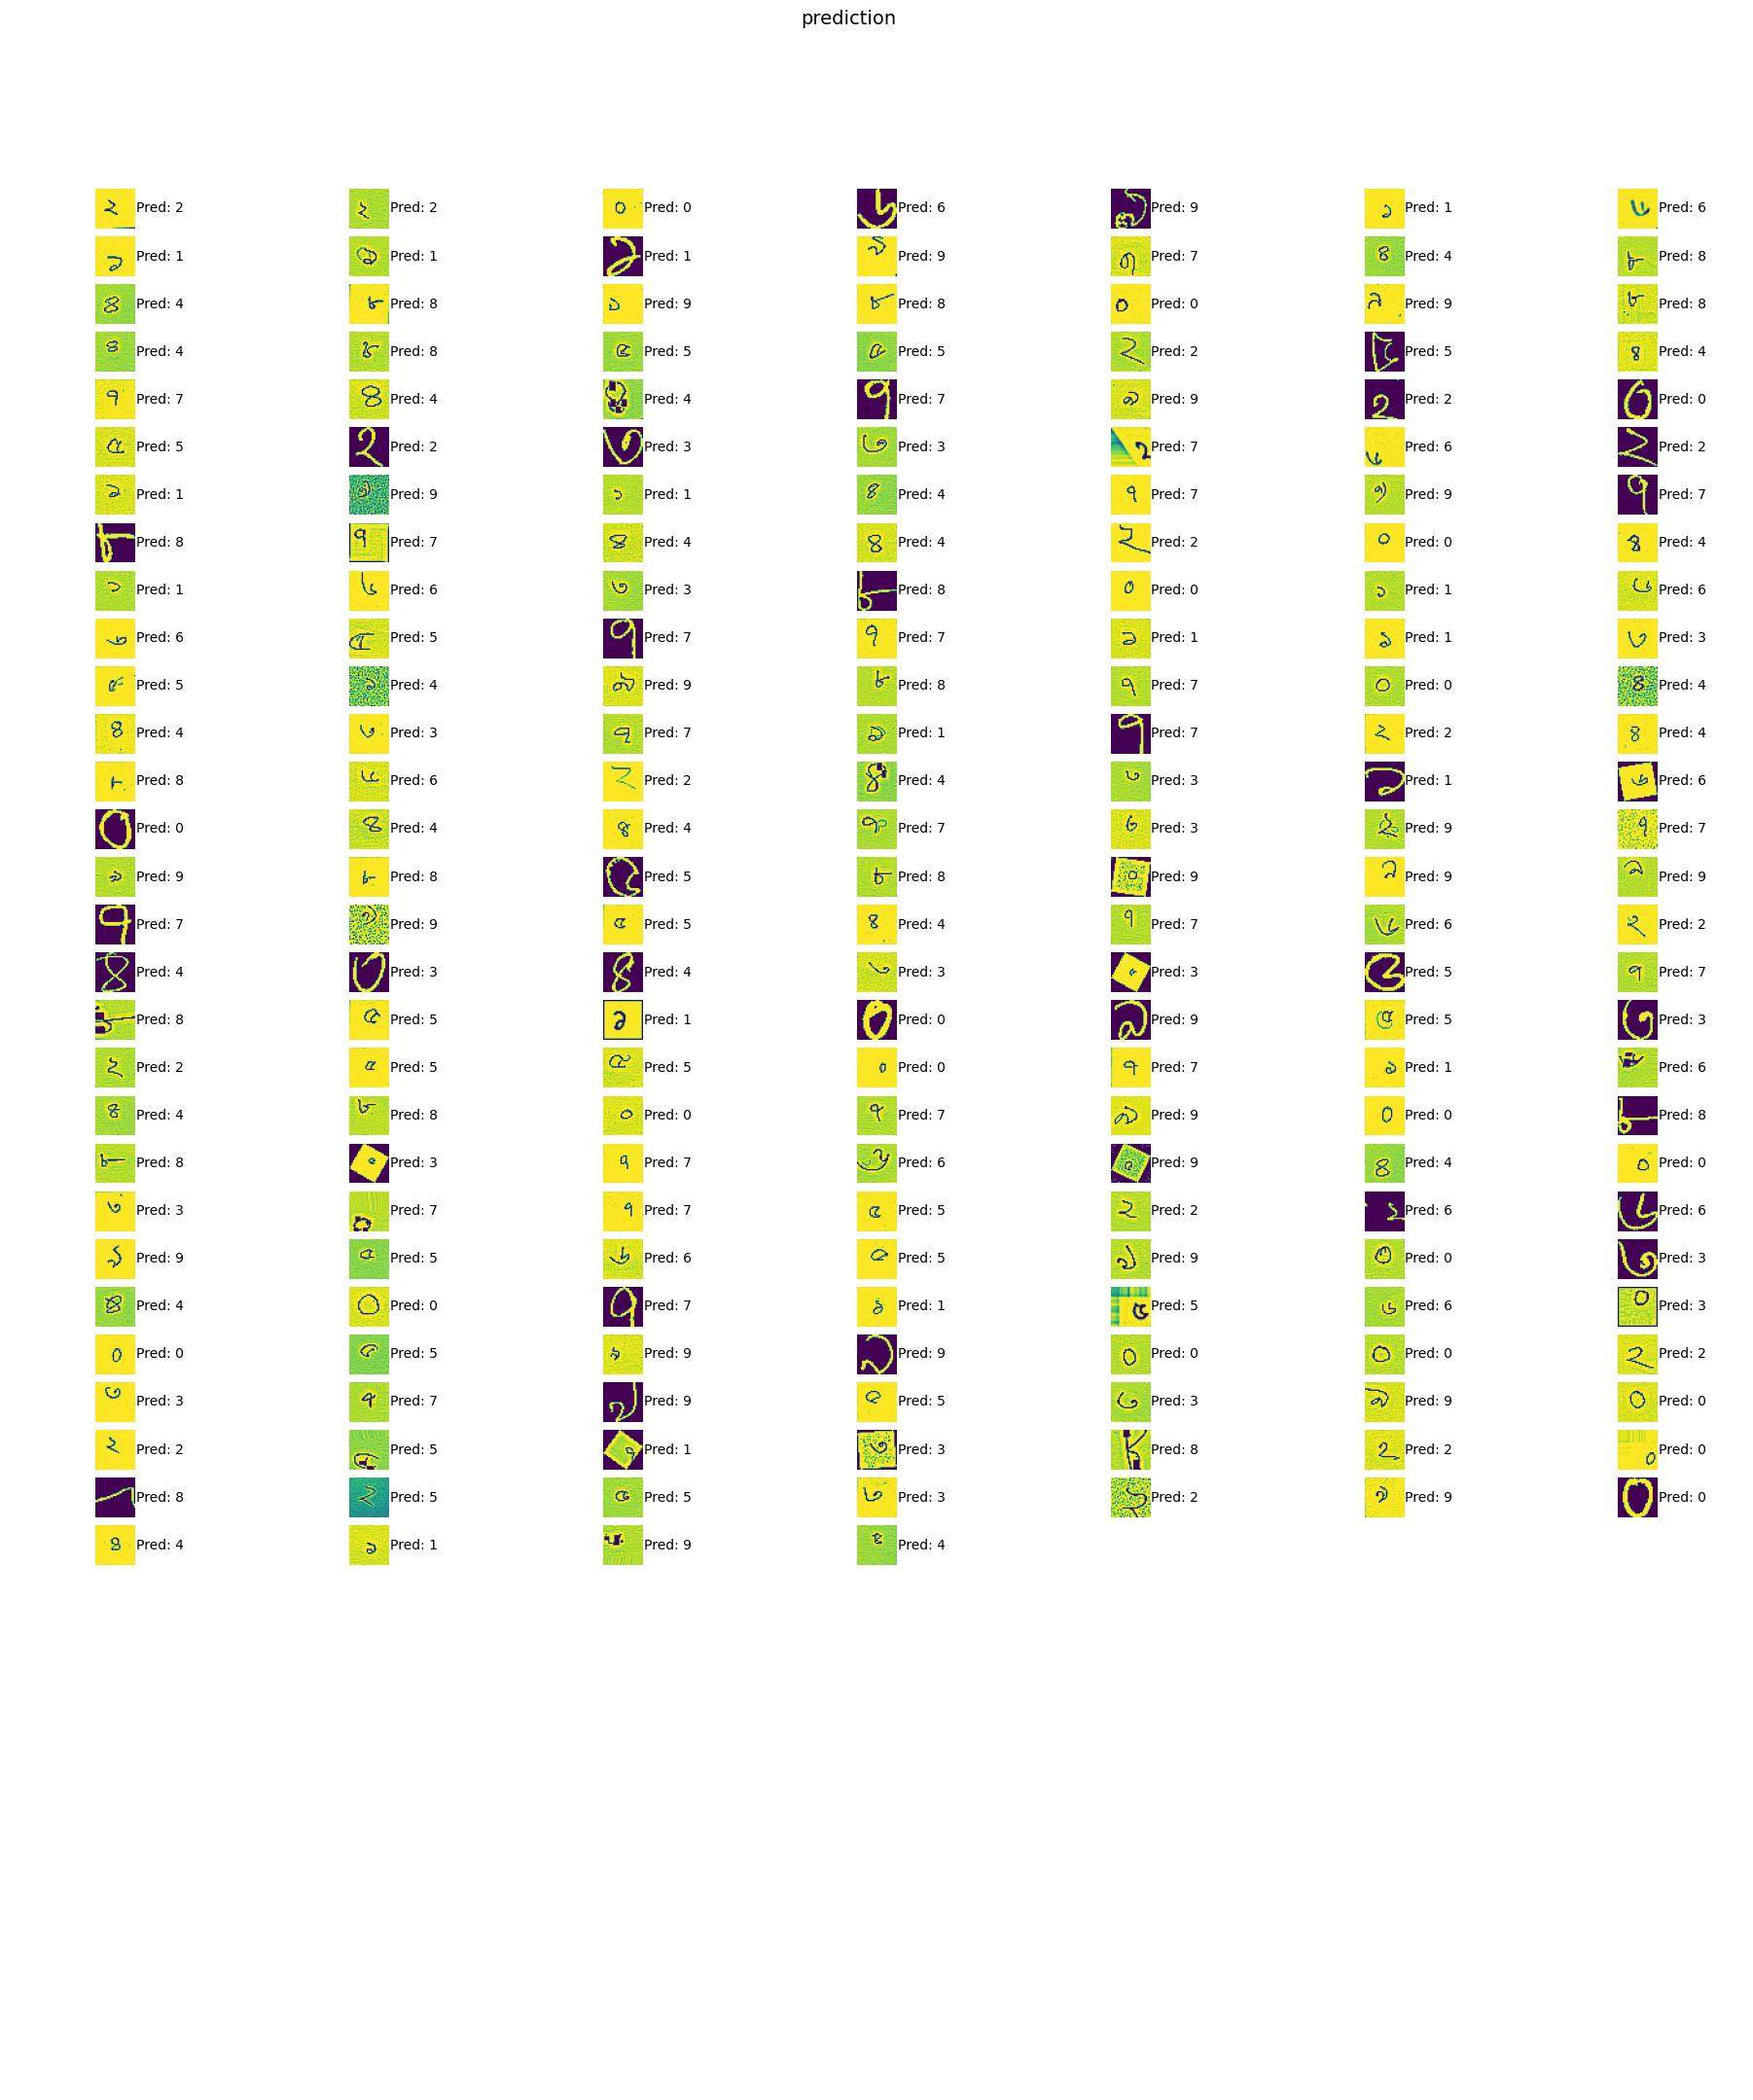

In [284]:
imshow_group(X=X_tshow_all[ind], y=None, y_pred=predictions_prob[ind], phase='prediction')


In [285]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [286]:
keys=[get_key(path) for path in paths_test_all ]

In [287]:
create_submission(predictions=labels,keys=keys,path='cnnsubmission32_final.csv')

In [288]:
prediction = pd.read_csv('cnnsubmission32_final.csv')
prediction.head(100)

,key,label
0,a00000.png,4
1,a00001.png,9
2,a00002.png,3
3,a00003.png,0
4,a00004.png,4
...,...,...
95,a00095.png,7
96,a00096.png,3
97,a00097.png,9
98,a00098.png,6
